In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
#from petitRADTRANS import Radtrans
#from petitRADTRANS import nat_cst as nc
%matplotlib inline
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams.update({'font.size': 12})
mpl.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
mpl.rc('text', usetex=True)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [2]:
true_transm = pd.read_hdf('../data/test_data_pinns.h5', key='transm')
atm_params = pd.read_hdf('../data/test_data_pinns.h5', key='params')

signal_strength = true_transm.values.max(axis=1) - true_transm.values.min(axis=1)

names = ['4x32', '6x32', '4x64', '6x64', '4x128', '6x128']

pinn_transm_all = {}
errors_all = {}
rel_errors_all = {}

for name in names:
    pinn_transm = []
    errors = []
    rel_errors = []
    for i in range(7):
        eval_filename = '../data/HPsearch/eval_data/eval_IsothermalAtmoAlt_' + name + f'_100x50_seed={i+1}.h5'
        #print(eval_filename)
        pinn_transm.append(pd.read_hdf(eval_filename, key='transm'))
        errors.append(pd.read_hdf(eval_filename, key='error'))
    
        rel_errors.append(errors[i].values / signal_strength[:,None])

    pinn_transm_all.update({name: np.array(pinn_transm)})
    errors_all.update({name: np.array(errors)})
    rel_errors_all.update({name: np.array(rel_errors)})

r_jup_mean = 69.911e6 * 1e2
c = 3e8 * 1e2

In [3]:
mask = np.ones(100, dtype=bool)
mask = atm_params.iloc[:,5]>0.2
print(np.arange(100)[~mask], np.sum(mask))

all_sq_mean_rel_errors = {}
sq_mean_rel_errors = {}
mean_rel_errors = {}

for name in names:
    all_sq_mean_rel_err = []
    sq_mean_rel_err_mean_std = []
    mean_rel_err_mean_std = []
    for i in range(7):
        all_sq_mean_rel_error = np.sqrt(np.mean(rel_errors_all[name][i]**2, axis=1))[mask]
        mean_rel_error = np.mean(rel_errors_all[name][i], axis=1)[mask]
        std_rel_error  =  np.std(rel_errors_all[name][i], axis=1)[mask]
        #print('Min Error: ', np.argsort(sq_mean_rel_error)[:5])
        #print('Max Error: ', np.argsort(sq_mean_rel_error)[-5:])
        #print('Mean Error: ', np.round(np.mean(sq_mean_rel_error)*100, 2), '+-', np.round(np.std(sq_mean_rel_error)*100, 2), '%')
        all_sq_mean_rel_err.append(all_sq_mean_rel_error)
        sq_mean_rel_error = np.array([np.mean(all_sq_mean_rel_error), np.std(all_sq_mean_rel_error)])
        sq_mean_rel_err_mean_std.append(sq_mean_rel_error)
        mean_rel_error = np.array([np.mean(mean_rel_error), np.std(mean_rel_error)])
        mean_rel_err_mean_std.append(mean_rel_error)

    all_sq_mean_rel_errors.update({name: np.array(all_sq_mean_rel_err)})
    sq_mean_rel_errors.update({name: np.array(sq_mean_rel_err_mean_std)})
    mean_rel_errors.update({name: np.array(mean_rel_err_mean_std)})

[ 1  7 45 51 68] 95


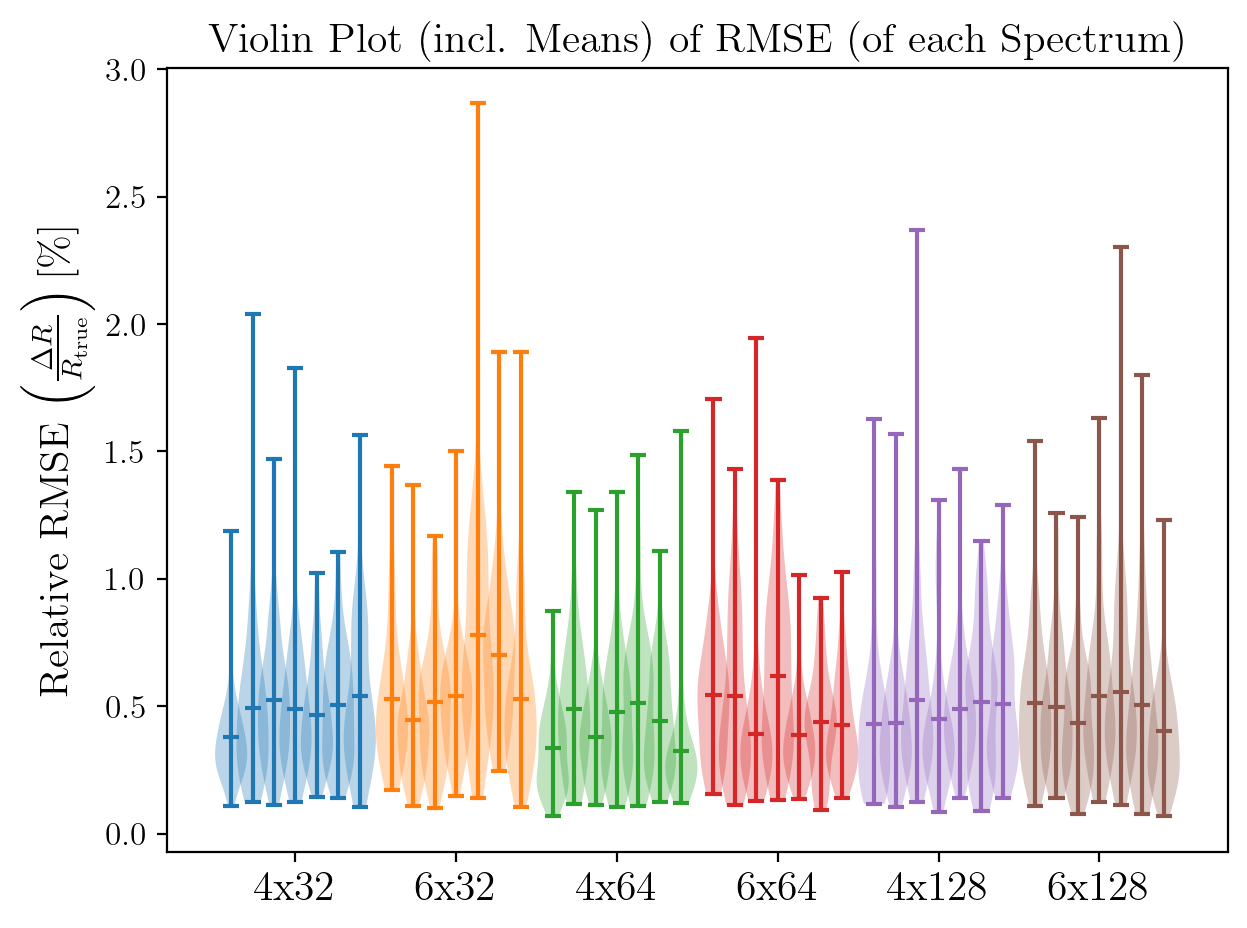

In [4]:
offsets = np.linspace(-0.4, 0.4, 7)

fontsize = 15
fig, ax = plt.subplots()

for idx, name in enumerate(names):
    #for offset, values in zip(offsets, all_sq_mean_rel_errors[name]):
        #print(values.shape)
        #print(np.array([idx + offset]).repeat(values.shape))
        #sns.violinplot(x=np.array([idx + offset]).repeat(values.shape), y=values*100, color=colors[idx], ax=ax)
    ax.violinplot(100*all_sq_mean_rel_errors[name].T, positions=(idx + offsets), widths=0.2, showmeans=True)

ax.set_xticks(np.arange(len(names)), names, fontsize=fontsize)
ax.set_ylabel(r'Relative RMSE $\left(\frac{\Delta R}{R_\mathrm{true}}\right) [\%]$', fontsize=fontsize)
ax.set_title(r'Violin Plot (incl. Means) of RMSE (of each Spectrum)', fontsize=fontsize)
fig.tight_layout()
#fig.savefig('../images/hp_search_errors.png', dpi=200)
fig.show()

## Alternative Measurements of Accuracy

(7, 2)


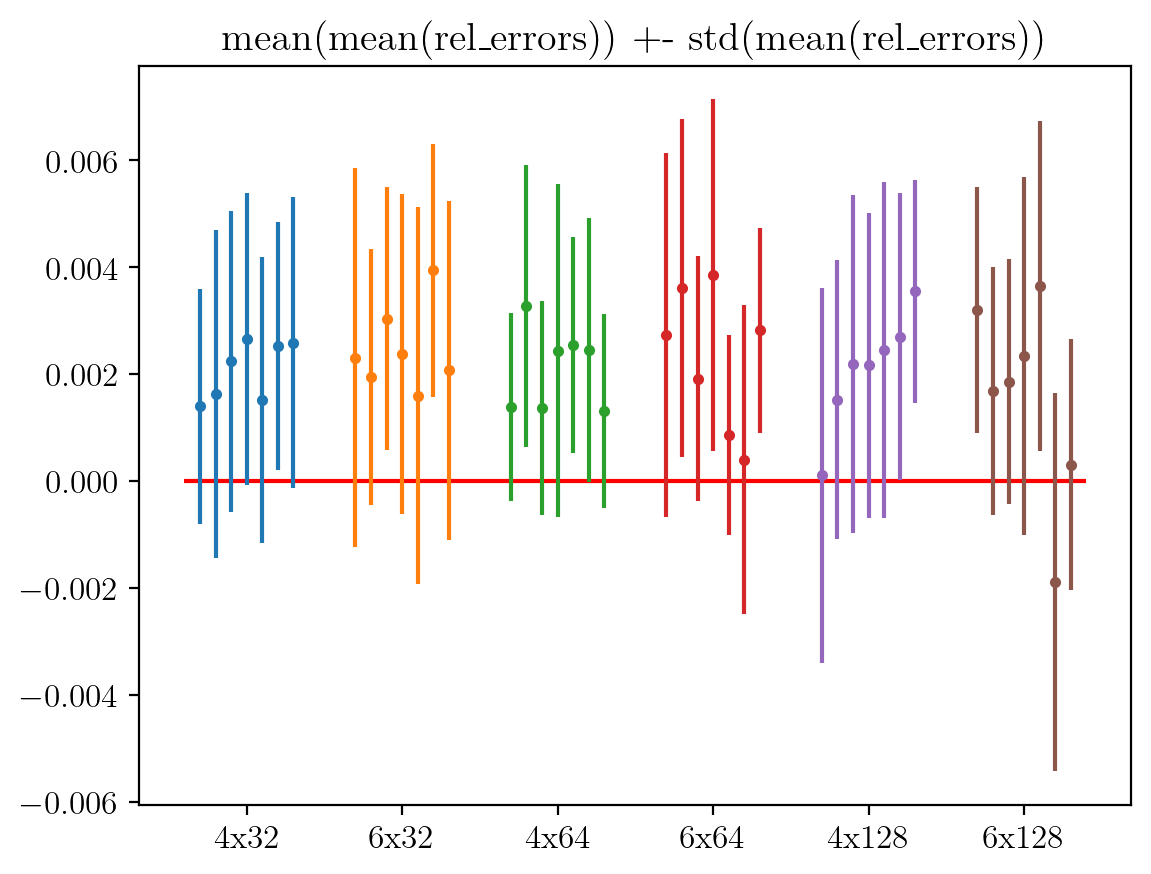

In [16]:
print(mean_rel_errors[names[0]].shape)

offsets = np.linspace(-0.3, 0.3, 7)

plt.hlines(0.0, xmin=-0.4, xmax=5.4, color='red')
for idx, name in enumerate(names):
    for offset, (mean, error) in zip(offsets, mean_rel_errors[name]):
        plt.errorbar(idx + offset, mean, yerr=error, fmt='.', color=colors[idx])
plt.xticks(range(len(names)), names)
plt.title('mean(mean(rel_errors)) +- std(mean(rel_errors))')
plt.show()

(7, 2)


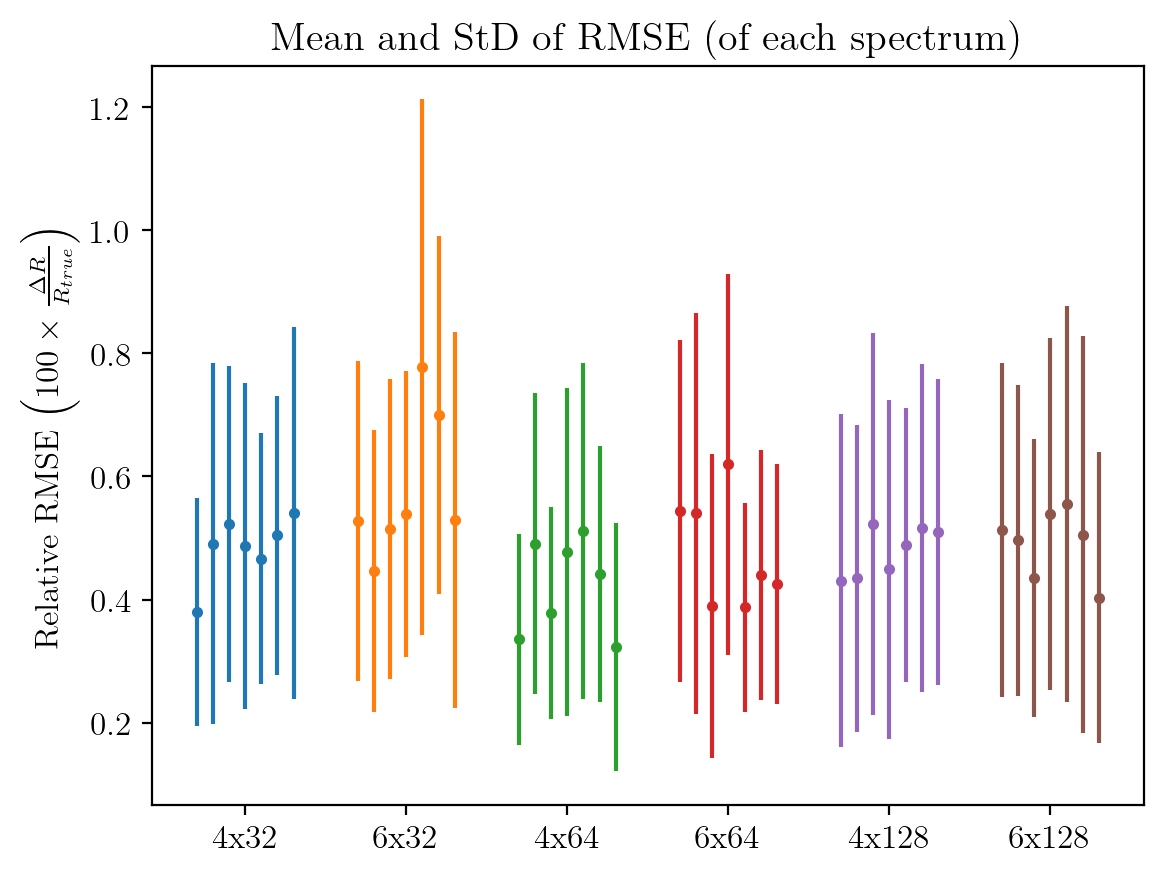

In [17]:
print(mean_rel_errors[names[0]].shape)

offsets = np.linspace(-0.3, 0.3, 7)

for idx, name in enumerate(names):
    for offset, (mean, error) in zip(offsets, sq_mean_rel_errors[name]):
        plt.errorbar(idx + offset, 100*mean, yerr=100*error, fmt='.', color=colors[idx])
plt.xticks(range(len(names)), names)
plt.ylabel(r'Relative RMSE $\left(100 \times \frac{\Delta R}{R_{true}}\right)$')
plt.title('Mean and StD of RMSE (of each spectrum)')
#plt.savefig('../images/hp_search_errors.png', dpi=200)
plt.show()

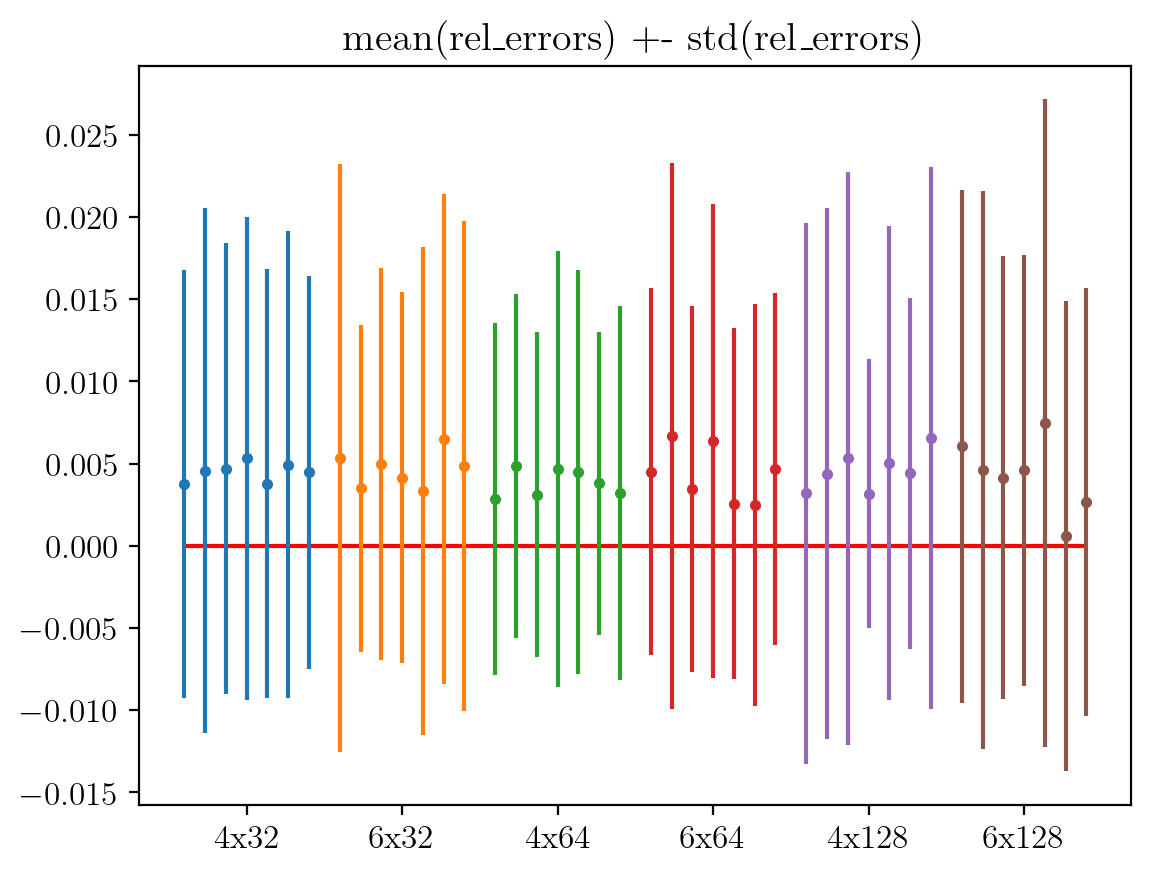

In [19]:
plt.hlines(0.0, xmin=-0.4, xmax=5.4, color='red')

for idx, name in enumerate(names):
    for offset, errors in zip(offsets, rel_errors_all[name].reshape(7,-1)):
        plot_err = errors
        plt.errorbar(idx + offset, plot_err.mean(), yerr=plot_err.std(), fmt='.', color=colors[idx])

plt.xticks(range(len(names)), names)
plt.title('mean(rel_errors) +- std(rel_errors)')
plt.show()

0.0050000000000000044


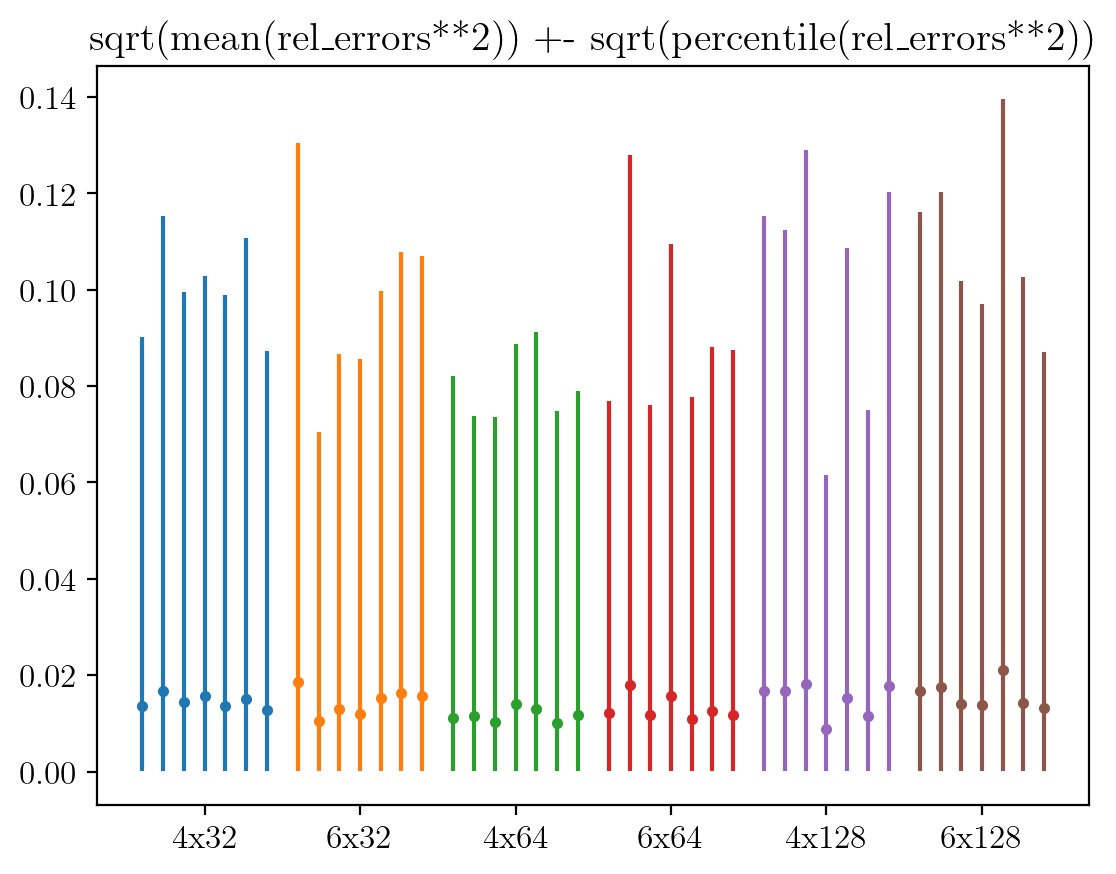

In [20]:
percentile = 0.99
perc_excl = (1.0-percentile)*0.5
print(perc_excl)

for idx, name in enumerate(names):
    for offset, errors in zip(offsets, rel_errors_all[name].reshape(7,-1)):
        plot_err = errors**2
        plot_err.sort()
        ind_min = int(np.round(plot_err.shape[0]*perc_excl))
        ind_max = int(np.round(plot_err.shape[0]*(1-perc_excl)))
        y_errorbars = np.array([plot_err[ind_min], plot_err[ind_max]])
        mean = np.sqrt((plot_err).mean())
        y_errorbars = np.abs(np.sqrt(y_errorbars)-mean)[:,None]
        plt.errorbar(idx + offset, mean, yerr=y_errorbars, fmt='.', color=colors[idx])

plt.xticks(range(len(names)), names)
plt.title('sqrt(mean(rel_errors**2)) +- sqrt(percentile(rel_errors**2))')
plt.show()

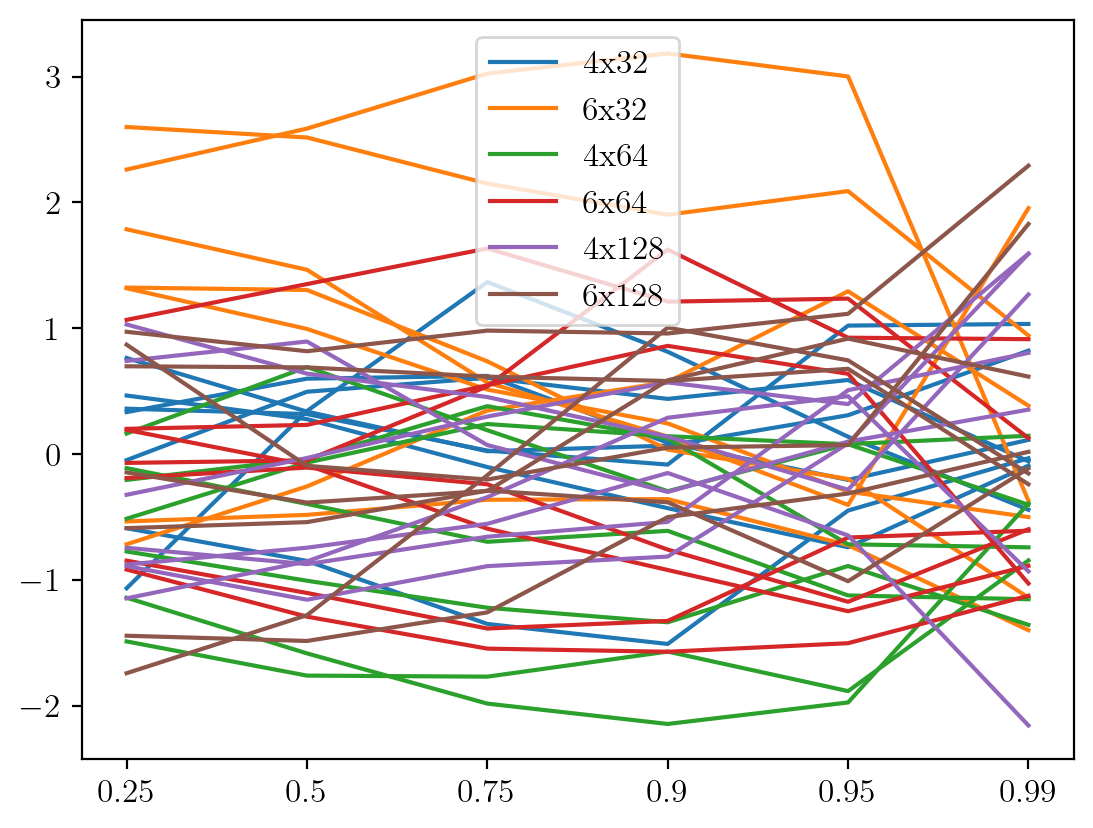

In [21]:
percentiles = np.array([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])#np.linspace(0,1,11)[1:-1]
perc_errors = np.zeros((len(names), 7, percentiles.shape[0]))

for idx, name in enumerate(names):
    for idseed, (offset, errors) in enumerate(zip(offsets, rel_errors_all[name].reshape(7,-1))):
        plot_err = np.abs(errors)
        plot_err.sort()
        indices = (plot_err.shape[0] * percentiles).astype(int) - 1
        plot_err = plot_err[indices]
        perc_errors[idx,idseed,:] = plot_err
        #plt.plot(percentiles, plot_err, '.', label=name, color=colors[idx])

means = np.mean(perc_errors.reshape(-1,percentiles.shape[0]), axis=0)
stds = np.std(perc_errors.reshape(-1,percentiles.shape[0]), axis=0)

for idx, name in enumerate(names):
    for idseed, errors in enumerate(perc_errors[idx]):
        if idseed==0:
            plt.plot(percentiles.astype('str'), (errors-means)/stds, color=colors[idx], label=names[idx])
        else:
            plt.plot(percentiles.astype('str'), (errors-means)/stds, color=colors[idx])

#plt.xscale('log')
plt.legend()